# K-Means to Segment Customers of Adobo Advantage Cards (AAC)

# 0. Import Dependencies

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

!pip install feature-engine

from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

# 1. Data Preprocessing

In [116]:
df = pd.read_csv('cc_dirty.csv')

### Check columns, dimensions, data types and null values of dataset

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111877 entries, 0 to 111876
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cc_num     111877 non-null  float64
 1   gender     111877 non-null  object 
 2   city       111877 non-null  object 
 3   city_pop   111877 non-null  object 
 4   job        103427 non-null  object 
 5   dob        111877 non-null  object 
 6   acct_num   111877 non-null  float64
 7   acct_num2  111877 non-null  float64
 8   trans_num  111877 non-null  object 
 9   unix_time  111877 non-null  int64  
 10  category   103318 non-null  object 
 11  amt        111877 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 10.2+ MB


In [118]:
df.shape

(111877, 12)

In [119]:
df.isna().sum()

cc_num          0
gender          0
city            0
city_pop        0
job          8450
dob             0
acct_num        0
acct_num2       0
trans_num       0
unix_time       0
category     8559
amt             0
dtype: int64

In [120]:
df.head(5)

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt
0,6.760000e+11,M,Dasmarinas,"659,019 people",Chartered loss adjuster,12/12/1958,7.980000e+11,7.980000e+11,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,$68.88
1,3.520000e+15,M,Digos,"169,393 people","Administrator, charities/voluntary organisations",31/08/1970,9.680000e+11,9.680000e+11,060d12f91c13871a13963041736a4702,1590902968,entertainment,$50.06
2,4.140000e+18,Male,Calapan,"133,893 people",Financial controller,23/07/1953,6.280000e+11,6.280000e+11,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,$105.44
3,4.870000e+15,M,San Fernando,"121,812 people",NaN,18/07/1964,8.630000e+11,8.630000e+11,45bbe714e51ab8a375454d39a190b0cb,1613063704,food_dining,$38.61
4,4.720000e+15,M,Laoag,"111,125 people",Dance movement psychotherapist,11/1/1954,2.570000e+11,2.570000e+11,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,$82.69


### Check unique values of categorical columns

In [121]:
categorical = ['gender', 'city', 'job', 'category']

In [122]:
for c in categorical:
    print('#########################')
    print(c)
    print('Unique Cateogries: ', df[c].unique()[:15])
    print('Count of Unique Categories: ', df[c].nunique())
    print()


#########################
gender
Unique Cateogries:  ['M' 'Male' 'F' 'Female']
Count of Unique Categories:  4

#########################
city
Unique Cateogries:  ['Dasmarinas' 'Digos' 'Calapan' 'San Fernando' 'Laoag' 'City of Paranaque'
 'Balanga' 'Masbate' 'Malaybalay' 'Antipolo' 'General Santos' 'Navotas'
 'Marikina City' 'Malabon' 'Palayan City']
Count of Unique Categories:  59

#########################
job
Unique Cateogries:  ['Chartered loss adjuster'
 'Administrator, charities/voluntary organisations' 'Financial controller'
 nan 'Dance movement psychotherapist' 'Engineer, water'
 'Education officer, museum' 'Manufacturing systems engineer'
 'Brewing technologist' 'Tourist information centre manager'
 'Seismic interpreter' 'Customer service manager'
 'Radiographer, diagnostic' 'Diplomatic Services operational officer'
 'Broadcast journalist']
Count of Unique Categories:  90

#########################
category
Unique Cateogries:  ['shopping_net' 'entertainment' 'food_dining' 'gas_

### Check duplicates on `trans_num`, `cc_num`, `acct_num`, `acct_num2`

**`trans_num`**

In [123]:
duplicates = df[df.duplicated()]
print('Total duplicate transactions: ', len(duplicates))

Total duplicate transactions:  11877


In [124]:
# Check if there are null values in the flagged duplicates.
duplicates.isnull().sum()

cc_num         0
gender         0
city           0
city_pop       0
job          882
dob            0
acct_num       0
acct_num2      0
trans_num      0
unix_time      0
category     951
amt            0
dtype: int64

**Quick sanity check if the details of duplicated transactions are actual duplicates.**

In [125]:
duplicates.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt
542,2.470000e+15,Male,San Fernando,"306,659 people","Surveyor, quantity",1/11/1935,5.810000e+11,5.810000e+11,5c3870bc2fba1f8b3053301d4755cc93,1619237689,gas_transport,$56.48
1399,6.760000e+11,Male,Dasmarinas,"659,019 people",Chartered loss adjuster,12/12/1958,7.980000e+11,7.980000e+11,10ec92c08938a39bfb9d78a2669b3b37,1586604673,grocery_pos,$84.71
1737,4.140000e+18,Male,Calapan,"133,893 people",Financial controller,23/07/1953,6.280000e+11,6.280000e+11,b511aabc59c44e85742fe271c50c5277,1605248178,grocery_pos,$116.35
2171,4.060000e+15,M,Valenzuela,"620,422 people",Operational investment banker,6/12/1963,2.310000e+11,2.310000e+11,7788194c54508b5ae6b7bc72b2c0c288,1618046260,entertainment,$4.77
2318,2.320000e+15,M,Binan,"333,028 people","Teacher, early years/pre",8/2/1960,6.640000e+11,6.640000e+11,9fc5855a3dd66dafd2f10103ed56dca9,1586698232,kids_pets,$30.91


In [126]:
dupe_trans_num = list(duplicates.trans_num[:5])
dupe_trans_num

['5c3870bc2fba1f8b3053301d4755cc93',
 '10ec92c08938a39bfb9d78a2669b3b37',
 'b511aabc59c44e85742fe271c50c5277',
 '7788194c54508b5ae6b7bc72b2c0c288',
 '9fc5855a3dd66dafd2f10103ed56dca9']

In [127]:
df[df['trans_num'].isin(dupe_trans_num)].sort_values('trans_num')

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt
1252,6.760000e+11,Male,Dasmarinas,"659,019 people",Chartered loss adjuster,12/12/1958,7.980000e+11,7.980000e+11,10ec92c08938a39bfb9d78a2669b3b37,1586604673,grocery_pos,$84.71
1399,6.760000e+11,Male,Dasmarinas,"659,019 people",Chartered loss adjuster,12/12/1958,7.980000e+11,7.980000e+11,10ec92c08938a39bfb9d78a2669b3b37,1586604673,grocery_pos,$84.71
322,2.470000e+15,Male,San Fernando,"306,659 people","Surveyor, quantity",1/11/1935,5.810000e+11,5.810000e+11,5c3870bc2fba1f8b3053301d4755cc93,1619237689,gas_transport,$56.48
542,2.470000e+15,Male,San Fernando,"306,659 people","Surveyor, quantity",1/11/1935,5.810000e+11,5.810000e+11,5c3870bc2fba1f8b3053301d4755cc93,1619237689,gas_transport,$56.48
557,4.060000e+15,M,Valenzuela,"620,422 people",Operational investment banker,6/12/1963,2.310000e+11,2.310000e+11,7788194c54508b5ae6b7bc72b2c0c288,1618046260,entertainment,$4.77
2171,4.060000e+15,M,Valenzuela,"620,422 people",Operational investment banker,6/12/1963,2.310000e+11,2.310000e+11,7788194c54508b5ae6b7bc72b2c0c288,1618046260,entertainment,$4.77
1092,2.320000e+15,M,Binan,"333,028 people","Teacher, early years/pre",8/2/1960,6.640000e+11,6.640000e+11,9fc5855a3dd66dafd2f10103ed56dca9,1586698232,kids_pets,$30.91
2318,2.320000e+15,M,Binan,"333,028 people","Teacher, early years/pre",8/2/1960,6.640000e+11,6.640000e+11,9fc5855a3dd66dafd2f10103ed56dca9,1586698232,kids_pets,$30.91
1346,4.140000e+18,Male,Calapan,"133,893 people",Financial controller,23/07/1953,6.280000e+11,6.280000e+11,b511aabc59c44e85742fe271c50c5277,1605248178,grocery_pos,$116.35
1737,4.140000e+18,Male,Calapan,"133,893 people",Financial controller,23/07/1953,6.280000e+11,6.280000e+11,b511aabc59c44e85742fe271c50c5277,1605248178,grocery_pos,$116.35


**`acct_num` and `acct_num2`**

In [128]:
print('Total no. of entries: ', df.shape[0])
print('Number of rows where acct_num equal acct_num2: ', (df['acct_num'] == df['acct_num2']).sum())

Total no. of entries:  111877
Number of rows where acct_num equal acct_num2:  111877


In [129]:
# check unique users based on the combination of their cc_num and acct_num.
cc_acct_unique = df.copy()
cc_acct_unique = cc_acct_unique.drop_duplicates(subset=['cc_num', 'acct_num']) # timmy replaced dupes to unique originally: cc_acct_dupes.drop_duplicates
print('Number of unique users based on the combination of cc_num and acct_num: ', cc_acct_unique.shape[0])

Number of unique users based on the combination of cc_num and acct_num:  94


In [130]:
# check for the number unique users with same cc_num and acct_num
cc_dupes = cc_acct_unique['cc_num'].value_counts()
acct_dupes = cc_acct_unique['acct_num'].value_counts()

In [131]:
cc_dupes.info()

<class 'pandas.core.series.Series'>
Float64Index: 69 entries, 180000000000000.0 to 4160000000000000.0
Series name: cc_num
Non-Null Count  Dtype
--------------  -----
69 non-null     int64
dtypes: int64(1)
memory usage: 1.1 KB


In [132]:
print('Number of unique cc_nums assigned to multiple users: ', (cc_dupes.value_counts()>1).sum())
print('Number of unique acct_nums assigned to multiple users: ', (acct_dupes.value_counts()>1).sum())

Number of unique cc_nums assigned to multiple users:  3
Number of unique acct_nums assigned to multiple users:  2


In [133]:
cc_dupes_idx = list(cc_dupes[cc_dupes > 1].index)
acct_dupes_idx = list(acct_dupes[acct_dupes > 1].index)

In [134]:
# further inspection of duplicate cc_nums
cc_acct_unique[cc_acct_unique['cc_num'].isin(cc_dupes_idx)].sort_values('cc_num').head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt
3347,5.020000e+11,M,Marikina City,"450,741 people",Oncologist,23/09/1953,4.700000e+11,4.700000e+11,4d07b2d3a78dfb9ff9a50afba4d1b2c6,1580077155,shopping_net,"$1,019.59"
34,5.020000e+11,M,Tacloban,"242,089 people",Aid worker,20/05/1949,5.630000e+11,5.630000e+11,d1095af4f82e50db5f136c221fbbfd31,1589961749,shopping_pos,$5.95
64,6.390000e+11,M,City of Calamba,"454,486 people",Management consultant,29/05/1958,4.340000e+11,4.340000e+11,d06c7c63df75fce6c28be407443a18ec,1592619731,entertainment,$1.37
69,6.390000e+11,Female,Dumaguete City,"131,377 people","Accountant, chartered certified",12/1/1942,8.780000e+11,8.780000e+11,a92398481ef9780e84cde741d2762837,1588128951,misc_net,$131.21
25292,6.390000e+11,Male,Marikina City,"450,741 people",Youth worker,5/9/1954,1.380000e+11,1.380000e+11,333c14ef4a67a6ef4e9d0d9858029a99,1606256080,shopping_net,"$1,058.48"


In [135]:
# further inspection of duplicate acct_nums
cc_acct_unique[cc_acct_unique['acct_num'].isin(acct_dupes_idx)].sort_values('acct_num').head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt
7,1.800000e+14,Male,Balanga,"96,061 people",Manufacturing systems engineer,14/05/1950,2.330000e+11,2.330000e+11,c371800cdd75b7373b0a883e9ea38450,1633018557,kids_pets,$47.87
67,4.100000e+18,Male,Tagbilaran City,"105,051 people",Land,10/2/1963,2.330000e+11,2.330000e+11,aaed8d5a1be5082b37cd9f79c4ee29ab,1633055110,entertainment,$29.99
18,6.550000e+15,Male,Malaybalay,"174,625 people",English as a foreign language teacher,31/12/1948,5.810000e+11,5.810000e+11,8dc0edcc4d905534a7e9bc030727a73d,1588555732,misc_net,$116.15
256,2.470000e+15,Male,San Fernando,"306,659 people","Surveyor, quantity",1/11/1935,5.810000e+11,5.810000e+11,3e73eec2f213342c8be153689cd803bf,1578025343,grocery_pos,$106.67
1339,2.280000e+15,Female,Dipolog,"130,759 people",Archivist,10/2/1963,5.810000e+11,5.810000e+11,07026178dea7617bc4b8171e029bee88,1589220829,personal_care,$72.56


In [136]:
# check if creating a new identifier by combining cc_num and acct_num will eliminate duplicates
df_check = df.copy()
cust_id = df_check['cc_num'].astype('int64').astype('string') + df_check['acct_num'].astype('int64').astype('string')
df_check.insert(0, 'cust_id', cust_id)

In [137]:
print('Unique customers based on new identifier cust_id: ', len(df_check['cust_id'].drop_duplicates()))

Unique customers based on new identifier cust_id:  94


In [138]:
# check if there is more than one instance of the cust_ids
(df_check['cust_id'].drop_duplicates().value_counts()>1).sum()

0

In [139]:
df_check.head()

,cust_id,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt
0,676000000000798000000000,6.760000e+11,M,Dasmarinas,"659,019 people",Chartered loss adjuster,12/12/1958,7.980000e+11,7.980000e+11,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,$68.88
1,3520000000000000968000000000,3.520000e+15,M,Digos,"169,393 people","Administrator, charities/voluntary organisations",31/08/1970,9.680000e+11,9.680000e+11,060d12f91c13871a13963041736a4702,1590902968,entertainment,$50.06
2,4140000000000000000628000000000,4.140000e+18,Male,Calapan,"133,893 people",Financial controller,23/07/1953,6.280000e+11,6.280000e+11,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,$105.44
3,4870000000000000863000000000,4.870000e+15,M,San Fernando,"121,812 people",NaN,18/07/1964,8.630000e+11,8.630000e+11,45bbe714e51ab8a375454d39a190b0cb,1613063704,food_dining,$38.61
4,4720000000000000257000000000,4.720000e+15,M,Laoag,"111,125 people",Dance movement psychotherapist,11/1/1954,2.570000e+11,2.570000e+11,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,$82.69


### Observations:
1. We need to convert the `city_pop` and `amt` columns into numerical values. These are currently assigned with object dtype due to unnecessary strings ('people', ',' and '$')
2. The `dob` and `unix_time` columns will have to be converted into datetime format to be useable. For `dob`, the given format appears to be dd/mm/yyyy.
3. The `gender` column needs to be made uniform as there are entries with 'M', 'Male', 'F' and 'Female.' We will opt to replace 'Male' and 'Female' into 'M' and 'F' respectively.
4. Entries in the `city` column have an inconsistent format. We will remove strings such as 'City of ' and ' City' to make the names uniform and easier to sort alphabetically.  
5. Entries in the `job` column will be converted to lower case. The 8450 null values detected will be assigned with 'unspecified' as the value.
6. 8559 rows with null values in `category` will be removed as there is no way to know the category of the purchase. There are some entries with '_net' and '_pos' prefix. We will assume that these are online and pos terminal transactions respectively.
7. We detected 11877 duplicate transactions based on trans_num, which will be dropped.
8. There are cases of two or more unique users being assigned the same cc_num and acct_num. For example, cc_num 5.020000e+11 has two records that have completely different information on city, job, dob and acct_num. Meanwhile, acct_num 2.330000e+11 is assigned 2 unique cc_nums, which may possibly mean supplementary cards for a single account. We will treat these cases as unique users and create a new identifier that combines cc_num and acct_num.

### Data Cleanup

In [140]:
df_cleaned = df.copy()

In [141]:
# clean up strings in city_pop column, convert to numeric
df_cleaned['city_pop']=df_cleaned['city_pop'].str.replace(" people","")
df_cleaned['city_pop']=df_cleaned['city_pop'].str.replace(",","")
df_cleaned['city_pop'] = pd.to_numeric(df_cleaned['city_pop'])

# clean up strings in amt column, convert to numeric
df_cleaned['amt'] = df_cleaned['amt'].str.replace('$', '')
df_cleaned['amt'] = pd.to_numeric(df_cleaned['amt'].str.replace(',', ''))


In [142]:
# convert dob and unix_time columns into datetime
df_cleaned['dob'] = pd.to_datetime(df_cleaned['dob'], dayfirst=True)
df_cleaned['unix_time'] = pd.to_datetime(df_cleaned['unix_time'], unit='s')

In [143]:
# make the gender column uniform by replacing 'Male' with 'M' and 'Female' with 'F'
df_cleaned['gender']=df_cleaned['gender'].str.replace("Male","M")
df_cleaned['gender']=df_cleaned['gender'].str.replace("Female","F")

In [144]:
# remove 'City of ' and ' City' in the city column
df_cleaned['city'] = df_cleaned['city'].str.replace('City of ', '')
df_cleaned['city'] = df_cleaned['city'].str.replace(' City', '')

In [145]:
# convert job column to lowercase and fill null values as 'unspecified'
df_cleaned['job'] = df_cleaned['job'].str.lower().fillna('unspecified')

In [146]:
# remove rows with null values in the category column
df_cleaned = df_cleaned.dropna(subset=['category'])

In [147]:
# remove duplicate transactions
df_cleaned = df_cleaned.drop_duplicates()

### Double Check Cleaned Data

In [148]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92392 entries, 0 to 111875
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   cc_num     92392 non-null  float64       
 1   gender     92392 non-null  object        
 2   city       92392 non-null  object        
 3   city_pop   92392 non-null  int64         
 4   job        92392 non-null  object        
 5   dob        92392 non-null  datetime64[ns]
 6   acct_num   92392 non-null  float64       
 7   acct_num2  92392 non-null  float64       
 8   trans_num  92392 non-null  object        
 9   unix_time  92392 non-null  datetime64[ns]
 10  category   92392 non-null  object        
 11  amt        92392 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(1), object(5)
memory usage: 9.2+ MB


In [149]:
df_cleaned.isna().sum()

cc_num       0
gender       0
city         0
city_pop     0
job          0
dob          0
acct_num     0
acct_num2    0
trans_num    0
unix_time    0
category     0
amt          0
dtype: int64

In [150]:
df_cleaned.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt
0,6.760000e+11,M,Dasmarinas,659019,chartered loss adjuster,1958-12-12,7.980000e+11,7.980000e+11,a72eaa86b043eed95b25bbb25b3153a1,2020-02-10 05:53:31,shopping_net,68.88
1,3.520000e+15,M,Digos,169393,"administrator, charities/voluntary organisations",1970-08-31,9.680000e+11,9.680000e+11,060d12f91c13871a13963041736a4702,2020-05-31 05:29:28,entertainment,50.06
2,4.140000e+18,M,Calapan,133893,financial controller,1953-07-23,6.280000e+11,6.280000e+11,18aafb6098ab0923886c0ac83592ef8d,2020-03-29 05:52:37,food_dining,105.44
3,4.870000e+15,M,San Fernando,121812,unspecified,1964-07-18,8.630000e+11,8.630000e+11,45bbe714e51ab8a375454d39a190b0cb,2021-02-11 17:15:04,food_dining,38.61
4,4.720000e+15,M,Laoag,111125,dance movement psychotherapist,1954-01-11,2.570000e+11,2.570000e+11,c20ee88b451f637bc6893b7460e9fee0,2020-09-28 08:35:59,gas_transport,82.69


### Simple Feature Engineering

**We plan to add the following features to aid in exploratory data analysis.**
* `age` - Computed using the `dob` column. For this analysis, we will assume the date today will be September 15, 2023.
* `trans_year` - Isolate the year portion of `unix_time`.
* `trans_year_month` - Isolate the year and month portion of `unix_time`.
* `cust_id` - Create a new identifier based on the combination of cc_num and acct_num as per observation # 8.

In [151]:
# Create age column

# Assume date today is September 15, 2023.
today = pd.to_datetime('2023-09-15')

# Calculate age in years
age_days = today - df_cleaned['dob']
age_years = age_days // pd.Timedelta(days=365.25)

# Insert age column in df_cleaned
df_cleaned.insert(loc=6, column='age', value= age_years)

In [152]:
# Create `trans_date` column
trans_year = pd.to_datetime(df_cleaned['unix_time']).dt.strftime('%Y')
trans_month = pd.to_datetime(df_cleaned['unix_time']).dt.strftime('%m')
trans_year_month = pd.to_datetime(df_cleaned['unix_time']).dt.strftime('%Y-%m')

df_cleaned.insert(loc=11, column='trans_year', value=trans_year)
df_cleaned.insert(loc=12, column='trans_month', value=trans_month)
df_cleaned.insert(loc=13, column='trans_year_month', value=trans_year_month)

In [153]:
# Create cust_id column
cust_id = df_cleaned['cc_num'].astype('int64').astype('string') + df_cleaned['acct_num'].astype('int64').astype('string')
df_cleaned.insert(0, 'cust_id', cust_id)

In [154]:
# Simplify cust_id
cust_num = np.arange(1, 95)
cust_id_arr = np.array(df_cleaned['cust_id'].drop_duplicates())
mapping = dict(zip(cust_id_arr, cust_num))
df_cleaned['cust_id'] = df_cleaned['cust_id'].map(mapping)

In [155]:
df_cleaned.head()

,cust_id,cc_num,gender,city,city_pop,job,dob,age,acct_num,acct_num2,trans_num,unix_time,trans_year,trans_month,trans_year_month,category,amt
0,1,6.760000e+11,M,Dasmarinas,659019,chartered loss adjuster,1958-12-12,64,7.980000e+11,7.980000e+11,a72eaa86b043eed95b25bbb25b3153a1,2020-02-10 05:53:31,2020,02,2020-02,shopping_net,68.88
1,2,3.520000e+15,M,Digos,169393,"administrator, charities/voluntary organisations",1970-08-31,53,9.680000e+11,9.680000e+11,060d12f91c13871a13963041736a4702,2020-05-31 05:29:28,2020,05,2020-05,entertainment,50.06
2,3,4.140000e+18,M,Calapan,133893,financial controller,1953-07-23,70,6.280000e+11,6.280000e+11,18aafb6098ab0923886c0ac83592ef8d,2020-03-29 05:52:37,2020,03,2020-03,food_dining,105.44
3,4,4.870000e+15,M,San Fernando,121812,unspecified,1964-07-18,59,8.630000e+11,8.630000e+11,45bbe714e51ab8a375454d39a190b0cb,2021-02-11 17:15:04,2021,02,2021-02,food_dining,38.61
4,5,4.720000e+15,M,Laoag,111125,dance movement psychotherapist,1954-01-11,69,2.570000e+11,2.570000e+11,c20ee88b451f637bc6893b7460e9fee0,2020-09-28 08:35:59,2020,09,2020-09,gas_transport,82.69


# 2. EDA

### Check transaction count, and amount spent from 2020-2021

In [156]:
trans_vol = df_cleaned.groupby(['trans_year_month', 'trans_year', 'trans_month']).agg({'trans_num': 'count', 'amt': 'sum'})

#rescale amounts by dividing by 1000 for easier visualization
trans_vol['amt'] = trans_vol['amt']/1000

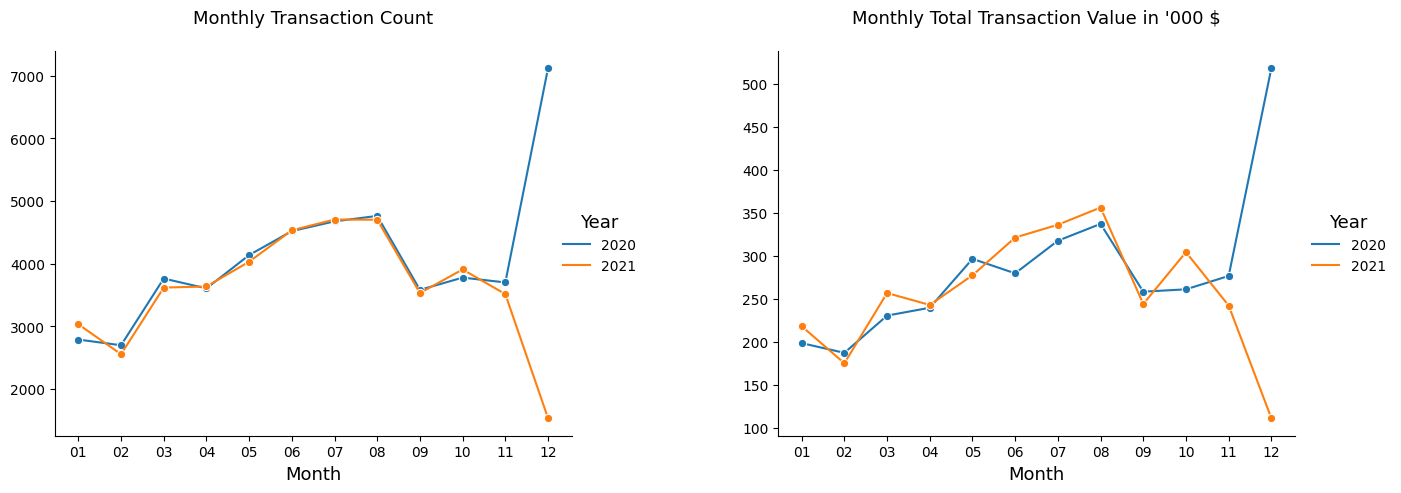

In [157]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.lineplot(data=trans_vol, x='trans_month', y='trans_num', hue='trans_year', marker='o').get_yaxis
plt.xlabel('Month', fontsize=13)
plt.ylabel('')
plt.title('Monthly Transaction Count', fontsize=13, y=1.05)
plt.legend(title='Year', title_fontsize=13, loc='right', bbox_to_anchor=(1.15, 0.5)).get_frame().set_linewidth(0)

plt.subplot(1, 2, 2)
sns.lineplot(data=trans_vol, x='trans_month', y='amt', hue='trans_year', marker='o')
plt.xlabel('Month', fontsize=13)
plt.ylabel('')
plt.title("Monthly Total Transaction Value in '000 $", fontsize=13,y=1.05)
plt.legend(title='Year', title_fontsize=13,loc='right', bbox_to_anchor=(1.2, 0.5)).get_frame().set_linewidth(0)

plt.subplots_adjust(wspace=0.4)
sns.despine()
plt.show();


In [158]:
last_trans_2020 = df_cleaned[df_cleaned.unix_time.dt.year==2020]['unix_time'].max()
last_trans_2021 = df_cleaned[df_cleaned.unix_time.dt.year==2021]['unix_time'].max()

print('The last transaction date in 2020 is: ', last_trans_2020)
print('The last transaction date in 2021 is: ', last_trans_2021)

The last transaction date in 2020 is:  2020-12-31 23:48:16
The last transaction date in 2021 is:  2021-12-06 23:50:42


In [159]:
no_dec_trans = df_cleaned[df_cleaned.unix_time.dt.month!=12]

In [160]:
totals = no_dec_trans.groupby(['trans_year']).agg({'trans_num': 'count', 'amt': 'sum'})
totals

,trans_num,amt
trans_year,,
2020,41993,2883867.67
2021,41748,2975511.32


In [161]:
round(((totals.iloc[1] - totals.iloc[0])/totals.iloc[0])*100,2)

trans_num   -0.58
amt          3.18
dtype: float64

**Observation**

While there appears to be a discrepancy in the volume on December, this because the dataset has full coverage on the transaction for the whole month of December 2020, but only includes transactions until December 6, 2021.
Considering only January - November, total transaction count did not exhibit growth and remained at the 42,000 level. 2020 and 2021 volumes are evenly matched on a month-to-month basis.
Meanwhile, total transaction value increased by 3.18% from 2.88M USD to 2.97M USD  with notable improvements on March, June-August and October.

The spike in transaction count and value on December and consequent low volume on January-February is expected due to holiday spending. However, there is a notable decrease in spending from September-November despite the start of 'ber' months in the Philippines where people start to prepare for Christmas holidays.

### Check distribution of unique customers over various criteria

**Separate 2020 and 2021 Data**

In [162]:
df_unique_2020 = df_cleaned[df_cleaned['trans_year']=='2020'].drop_duplicates(subset=['cust_id'])
df_unique_2021 = df_cleaned[df_cleaned['trans_year']=='2021'].drop_duplicates(subset=['cust_id'])

**Gender**

In [163]:
unique_cust = df_cleaned.groupby(['trans_year','gender']).agg({'cust_id':'nunique'})
unique_cust

cust_id
trans_year gender         
2020       F             6
           M            72
2021       F             6
           M            82

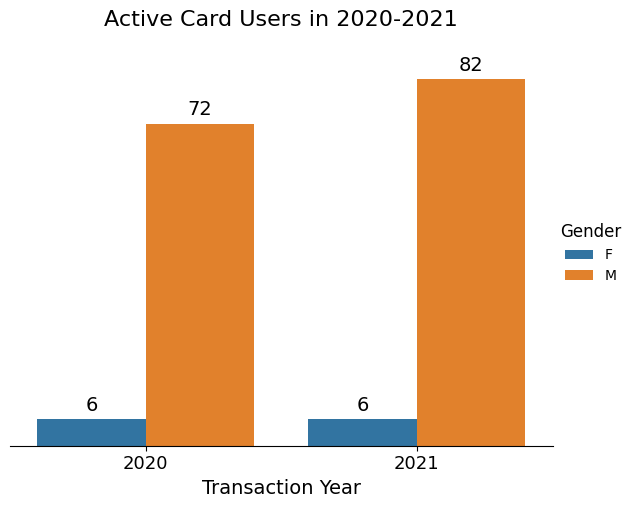

In [164]:
plt.figure(figsize=(7,5))

ax = sns.barplot(data=unique_cust.reset_index(), x='trans_year', y='cust_id', hue='gender')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=14, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.xlabel('Transaction Year', fontsize=14)
plt.xticks(fontsize=13)
plt.ylabel('Customer Count', fontsize=14)
plt.title('Active Card Users in 2020-2021', fontsize=16, pad=25)
legend = plt.legend(title='Gender', loc='right', bbox_to_anchor=(1.15, 0.5))
legend.get_frame().set_linewidth(0)
legend.get_title().set_fontsize(12)

sns.despine(left=True)
ax.get_yaxis().set_visible(False)

plt.show()

In [165]:
# check how many unique customers were retained from 2020
retained_cust = (df_unique_2020.cust_id).isin(df_unique_2021.cust_id).sum()
print('Total users retained from 2020: ', retained_cust)

# check how many customers customers were lost from 2020 and the new customers in 2021
lost_cust = (~(df_unique_2020.cust_id).isin(df_unique_2021.cust_id)).sum()
new_cust = (~(df_unique_2021.cust_id).isin(df_unique_2020.cust_id)).sum()

print('Customers lost from 2020: ', lost_cust)
print('New customers lost from 2020: ', new_cust)

# check if all female customers were retained
female_2020 = df_unique_2020[df_unique_2020.gender=='F'].cust_id
female_2021 = df_unique_2021[df_unique_2021.gender=='F'].cust_id
print('Female users retained from 2020 :', female_2020.isin(female_2021).sum())


Total users retained from 2020:  72
Customers lost from 2020:  6
New customers lost from 2020:  16
Female users retained from 2020 : 6


**Observation**

Total active users increased from 78 to 88 in 2021. A total of 72 users from 2020 remained active in 2021. The company gained 16 new users in 2021 and lost 6 unique users in 2020. Notably, all female users in 2020 remained active users the following year.

**Island**

In [166]:
df_cleaned['city'].nunique()

59

Since there are more than 59 cities, we will group them by island (NCR, Luzon, Visayas, Mindanao) instead for easier visualization.

In [167]:
city_mapping = pd.read_csv('city_mapping.csv')

In [168]:
city_mapping.columns

Index(['city', 'Province', 'Region', 'Island'], dtype='object')

In [169]:
# map city_mapping into df_cleaned
with_islands = df_cleaned.merge(city_mapping, on='city', how='left')

In [170]:
island_count = with_islands.groupby(['trans_year', 'Island'])['cust_id'].nunique().reset_index()
island_count

,trans_year,Island,cust_id
0,2020,Luzon,43
1,2020,Mindanao,12
2,2020,NCR,13
3,2020,Visayas,10
4,2021,Luzon,50
5,2021,Mindanao,14
6,2021,NCR,11
7,2021,Visayas,13


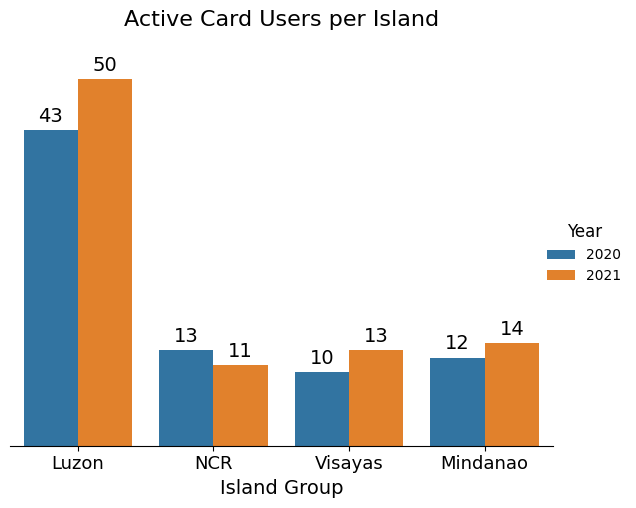

In [171]:
plt.figure(figsize=(7,5))

order = ['Luzon', 'NCR', 'Visayas', 'Mindanao']
ax = sns.barplot(data=island_count, x='Island', y='cust_id', hue='trans_year', order=order)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=14, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.xlabel('Island Group', fontsize=14)
plt.xticks(fontsize=13)
plt.title('Active Card Users per Island', fontsize=16, pad=25)
legend = plt.legend(title='Year', loc='right', bbox_to_anchor=(1.15, 0.5))
legend.get_frame().set_linewidth(0)
legend.get_title().set_fontsize(12)

sns.despine(left=True)
ax.get_yaxis().set_visible(False)

plt.show()

**Observation**

Active users are concentrated in the Luzon region (excluding NCR). Other islands are relatively equal in customer distribution.

**Age**

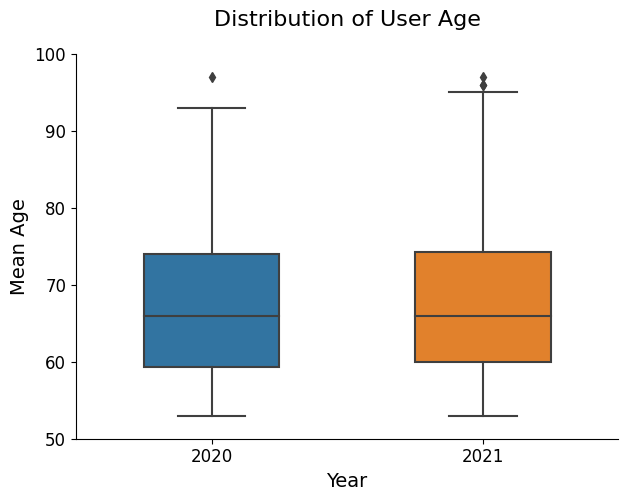

In [172]:
mean_age_per_customer = df_cleaned.groupby(['cust_id', 'trans_year'])['age'].mean().reset_index()

plt.figure(figsize=(7, 5))

# Create a box plot to show the distribution of mean age per year
sns.boxplot(data=mean_age_per_customer, x='trans_year', y='age', width=0.5)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Age', fontsize=14)
plt.title('Distribution of User Age', fontsize=16, pad=20)

plt.xticks(fontsize=12)
plt.yticks([50, 60, 70, 80, 90, 100], fontsize=12)

sns.despine()
plt.show()


In [173]:
mean_age_per_customer.describe()

,cust_id,age
count,166.000000,166.000000
mean,42.867470,68.554217
std,25.459544,11.221465
min,1.000000,53.000000
25%,21.250000,60.000000
50%,42.000000,66.000000
75%,62.750000,74.000000
max,94.000000,97.000000


**Observation**

Active users are an older demographic (53-97 years old).

### Check distribution of transaction count and total spending per category

**Check transaction count and amount spent per category**

In [174]:
categ = df_cleaned.groupby(['trans_year', 'category']).agg({'trans_num': 'count', 'amt': 'sum'}).reset_index()
categ_2021=categ[categ['trans_year']=='2021']

In [175]:
categ_2021_trans = categ_2021.sort_values('trans_num', ascending=False)
total_trans = categ_2021_trans['trans_num'].sum()
categ_2021_trans['trans_num_percent'] = (categ_2021_trans['trans_num'] / total_trans) * 100
categ_2021_trans['trans_cum'] = categ_2021_trans['trans_num_percent'].cumsum()

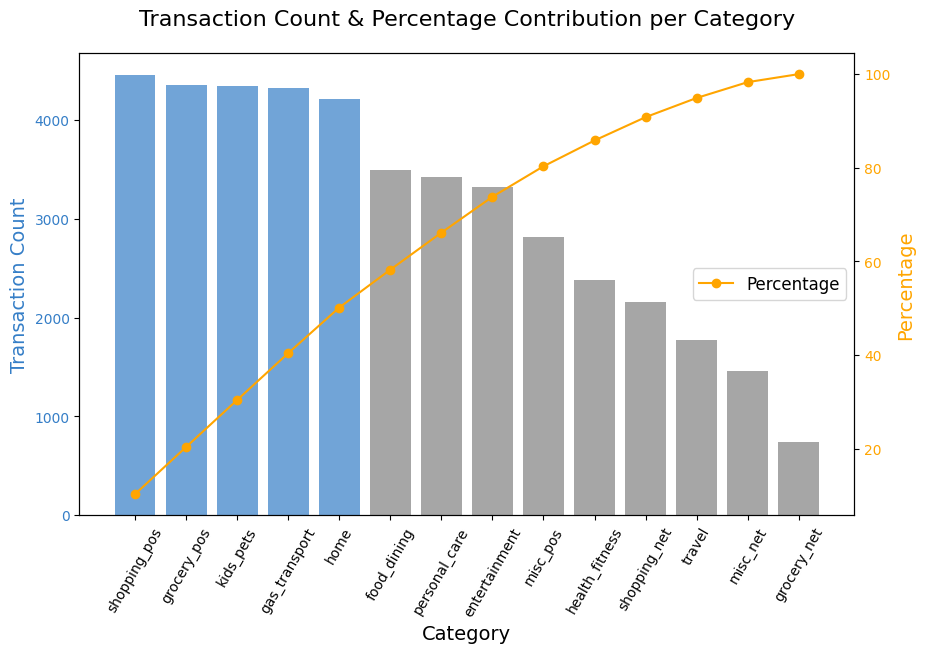

In [176]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Define the number of bars to highlight
num_bars_to_highlight = 5

# Create a list of colors, where the first 5 bars have a different color
colors = ['#357EC7' if i < num_bars_to_highlight else 'gray' for i in range(len(categ_2021))]

# Create the bar graph for total count
ax1.bar(categ_2021_trans['category'], categ_2021_trans['trans_num'], color= colors, alpha=0.7)
ax1.set_xlabel('Category', fontsize=14)
ax1.set_ylabel('Transaction Count', fontsize=14, color='#357EC7')
ax1.tick_params(axis='y', labelcolor='#357EC7')

ax1.set_xticklabels(categ_2021_trans['category'], rotation=60)

# Create a second y-axis for the line graph
ax2 = ax1.twinx()
ax2.plot(categ_2021_trans['category'], categ_2021_trans['trans_cum'], marker='o', color='orange', label='Percentage')
ax2.set_ylabel('Percentage', fontsize=14, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Display legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='right', fontsize=12)

plt.title('Transaction Count & Percentage Contribution per Category', fontsize=16, pad=20)
plt.xticks(fontsize=12)
plt.show()

In [177]:
categ_2021_amt = categ_2021.sort_values('amt', ascending=False)
total_amt = categ_2021['amt'].sum()
categ_2021_amt['amt_percent'] = (categ_2021_amt['amt'] / total_amt) * 100
categ_2021_amt['amt_cum'] = categ_2021_amt['amt_percent'].cumsum()

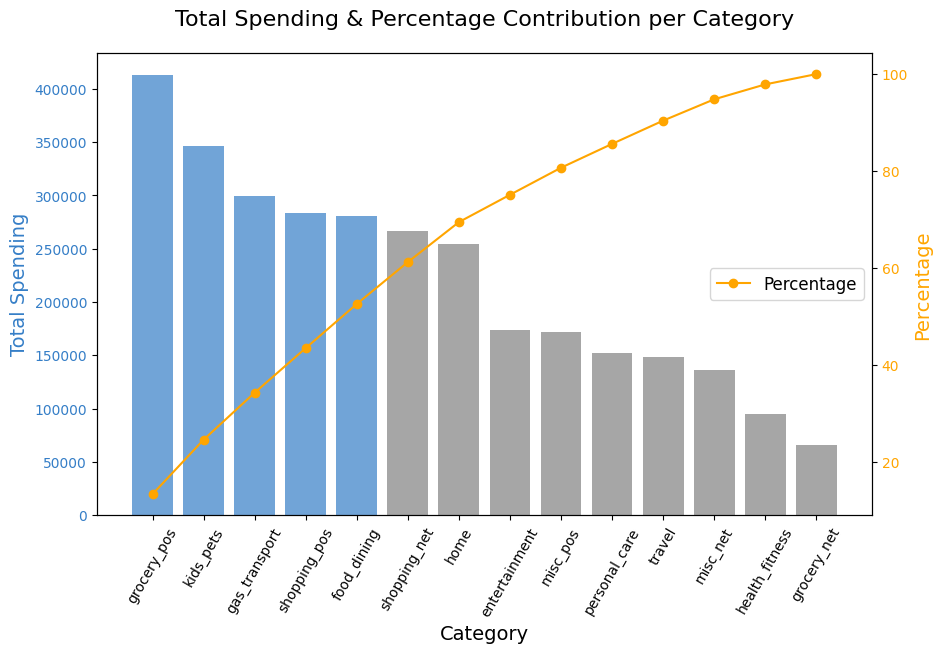

In [178]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Define the number of bars to highlight
num_bars_to_highlight = 5

# Create a list of colors, where the first 5 bars have a different color
colors = ['#357EC7' if i < num_bars_to_highlight else 'gray' for i in range(len(categ_2021_amt))]

# Create the bar graph for total count
ax1.bar(categ_2021_amt['category'], categ_2021_amt['amt'], color=colors, alpha=0.7)
ax1.set_xlabel('Category', fontsize=14)
ax1.set_ylabel('Total Spending', fontsize=14, color='#357EC7')
ax1.tick_params(axis='y', labelcolor='#357EC7')

ax1.set_xticklabels(categ_2021_amt['category'], rotation=60)

# Create a second y-axis for the line graph
ax2 = ax1.twinx()
ax2.plot(categ_2021_amt['category'], categ_2021_amt['amt_cum'], marker='o', color='orange', label='Percentage')
ax2.set_ylabel('Percentage', fontsize=14, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Display legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='right', fontsize=12)

plt.title('Total Spending & Percentage Contribution per Category', fontsize=16, pad=20)
plt.xticks(fontsize=12)
plt.show()

**Observation**
In both transaction count and total amount spent per category, 50% of the total is composed of the top 5 categories. In particular, the grocery_pos, kids_pet, gas_transport, and shopping_pos categories are the main contributors to total transaction count and total amount spent.

# 3. RFM Analysis

To get deeper insights on customer behavior, we plan to segment customers through Recency-Frequency-Monetary (RFM) Analysis. This will allow us to understand the length of time since a customer's last purchase, the frequency of their card usage and the total amount spent by customers. The RFM analysis will cover the data from January 1, 2021 to December 6, 2021 since the data from 2021 will best represent the customer base's current spending behaviour.

### Recency

In [179]:
# last invoice date for 2021
last_trans_2021 = df_cleaned[df_cleaned.unix_time.dt.year==2021]['unix_time'].max().date()
last_trans_2021

# last day of the year
end_of_year = pd.datetime(2021, 12, 31).date()
end_of_year

datetime.date(2021, 12, 31)

In [180]:
# create a df for 2021 transactions
df_2021 = df_cleaned[df_cleaned['trans_year']=='2021']
df_2021.head()

,cust_id,cc_num,gender,city,city_pop,job,dob,age,acct_num,acct_num2,trans_num,unix_time,trans_year,trans_month,trans_year_month,category,amt
3,4,4.870000e+15,M,San Fernando,121812,unspecified,1964-07-18,59,8.630000e+11,8.630000e+11,45bbe714e51ab8a375454d39a190b0cb,2021-02-11 17:15:04,2021,02,2021-02,food_dining,38.61
7,7,1.800000e+14,M,Balanga,96061,manufacturing systems engineer,1950-05-14,73,2.330000e+11,2.330000e+11,c371800cdd75b7373b0a883e9ea38450,2021-09-30 16:15:57,2021,09,2021-09,kids_pets,47.87
10,8,3.470000e+14,M,Antipolo,776386,seismic interpreter,1959-05-19,64,5.640000e+11,5.640000e+11,44fec72badccf385eec1f6bf27ccdf65,2021-02-10 18:13:45,2021,02,2021-02,personal_care,58.04
14,12,1.800000e+14,M,Marikina,450741,unspecified,1955-08-12,68,3.461474e+10,3.461474e+10,3a86393194aa83069765af258572b4cb,2021-03-08 03:29:16,2021,03,2021-03,shopping_pos,127.83
15,13,3.520000e+15,M,Malabon,365525,broadcast journalist,1957-04-05,66,5.870000e+11,5.870000e+11,c6fd5f74c9529755d5c190c1cf2b2610,2021-10-27 01:54:23,2021,10,2021-10,grocery_pos,89.45


In [181]:
# create a date column from the unix
df_2021['date'] = df_2021['unix_time'].dt.date

In [182]:
# create the recency table
df_recency = df_2021.groupby(['cust_id'], as_index=False)['date'].max()
df_recency['date'] = pd.to_datetime(df_recency['date'])
df_recency.columns = ['cust_id', 'last_purchase_date']
df_recency['recency'] = (end_of_year - df_recency['last_purchase_date'].dt.date).dt.days
df_recency.drop(columns=['last_purchase_date'], inplace=True)
df_recency.head()

,cust_id,recency
0,1,26
1,2,25
2,3,25
3,4,25
4,5,25


In [183]:
df_recency.describe()

,cust_id,recency
count,88.000000,88.000000
mean,45.193182,57.590909
std,26.593084,76.723363
min,1.000000,25.000000
25%,22.750000,25.000000
50%,44.500000,25.000000
75%,66.250000,26.000000
max,94.000000,340.000000


**Observation**

As per descriptive statistics table above, the recency values cannot be split into quartiles as the min, 25% and 50% values are the same. Since not having clear-cut boundaries for each quartile will affect our scoring method, we will instead compute recency as follows:
1. Take the latest 25% transactions of each unique customer based on `date`.
2. Compute the difference of each transaction's date with `last_trans`.
3. Compute the mean of the recency of the latest 25% transaction of each unique customer.

In [184]:
recency_mean = df_2021.copy()
recency_mean.sort_values(by=['cust_id', 'date'], inplace=True)
recency_mean['quantile'] = recency_mean.groupby('cust_id')['date'].transform(lambda x: x.quantile(0.75))
recency_mean = recency_mean[recency_mean['date'] >= recency_mean['quantile']]
recency_mean['recency'] = (end_of_year - recency_mean['date']).dt.days
df_recency = recency_mean.groupby('cust_id')['recency'].mean().reset_index()
df_recency.describe()

,cust_id,recency
count,88.000000,88.000000
mean,45.193182,88.445870
std,26.593084,64.202942
min,1.000000,52.250000
25%,22.750000,61.477366
50%,44.500000,64.462457
75%,66.250000,68.935248
max,94.000000,340.000000


Now the recency values have a more defined quartiles.

### Frequency and Monetary

In [185]:
df_fm = df_2021.groupby('cust_id').agg({'trans_num':'count',
                                            'amt': 'sum'})
df_fm.rename(columns={'trans_num': 'frequency', 'amt':'monetary'}, inplace=True)

### RFM Table

In [186]:
df_rfm = df_recency.merge(df_fm, left_on='cust_id', right_on='cust_id')
df_rfm.head()

,cust_id,recency,frequency,monetary
0,1,59.346154,307,23523.23
1,2,63.795918,972,56954.73
2,3,65.930131,909,57733.24
3,4,65.887446,922,65317.62
4,5,60.137168,897,62110.74


### Check skewness of data to determine if transformation is needed

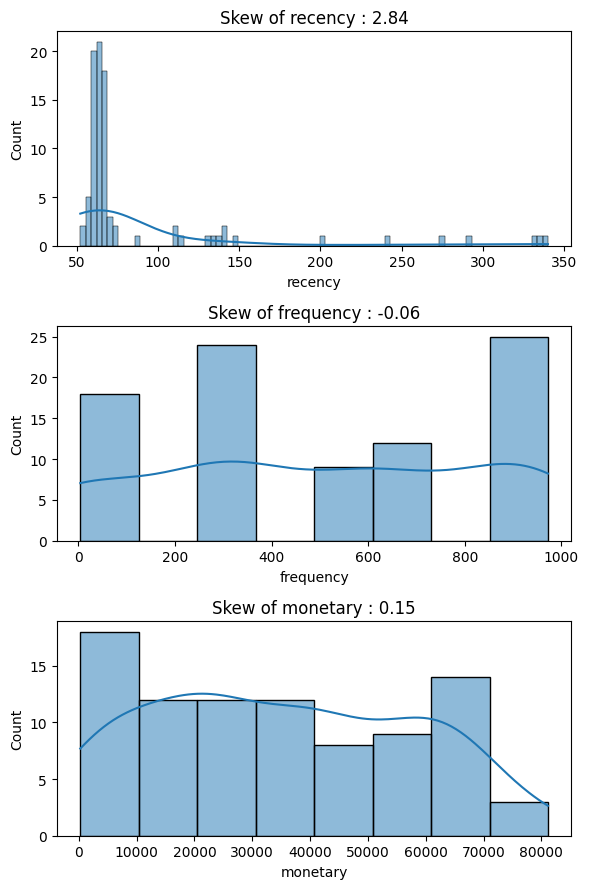

In [187]:
plt.figure(figsize=(6, 9))

for idx, col in enumerate(list(df_rfm.columns[1:])):
    skew = stats.skew(df_rfm[col])
    plt.subplot(3, 1, idx+1)
    sns.histplot(df_rfm, x=df_rfm[col], kde=True)
    plt.title('Skew of %s : %.2f' % (col, skew))

plt.tight_layout()

Since the skewness of recency is at 2.40, we will apply log transformation in an attempt to reduce the range of values. Frequency and Monetary values will be used as is.

Text(0.5, 1.0, 'Skew of log transformed recency: 2.16')

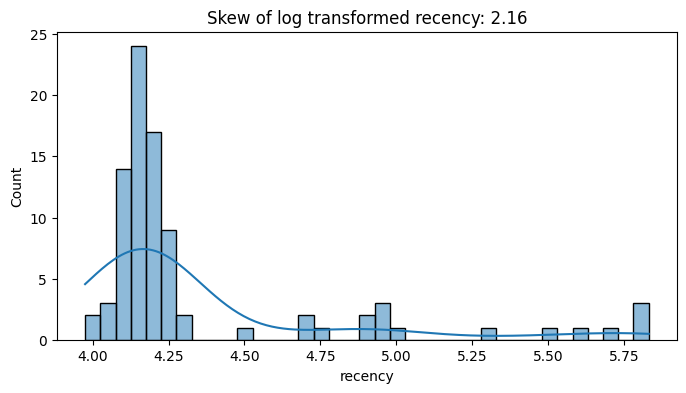

In [188]:
recency_log1p = np.log1p(df_rfm['recency'])

plt.figure(figsize=(8,4))

skew_log = stats.skew(recency_log1p)
sns.histplot(recency_log1p, kde=True)
plt.title('Skew of log transformed recency: %.2f' % (skew_log))

In [189]:
df_rfm['recency'] = recency_log1p
df_rfm.describe()

,cust_id,recency,frequency,monetary
count,88.000000,88.000000,88.000000,88.000000
mean,45.193182,4.358562,491.784091,35077.792273
std,26.593084,0.446775,336.474297,22482.797332
min,1.000000,3.974998,4.000000,244.260000
25%,22.750000,4.134803,297.250000,19095.285000
50%,44.500000,4.181475,581.000000,38254.740000
75%,66.250000,4.247568,878.500000,56524.657500
max,94.000000,5.831882,972.000000,81142.310000


**Winsorizer**

Winsorizer will be applied to further reduce the effects of extreme values.

In [190]:
wsr = Winsorizer(tail='both',
                 fold=2,
                 variables=['recency', 'frequency', 'monetary'])

In [191]:
df_wsr = wsr.fit_transform(df_rfm)

In [192]:
df_wsr.describe()

,cust_id,recency,frequency,monetary
count,88.000000,88.000000,88.000000,88.000000
mean,45.193182,4.326485,491.784091,35062.392962
std,26.593084,0.353738,336.474297,22451.325423
min,1.000000,3.974998,4.000000,244.260000
25%,22.750000,4.134803,297.250000,19095.285000
50%,44.500000,4.181475,581.000000,38254.740000
75%,66.250000,4.247568,878.500000,56524.657500
max,94.000000,5.247021,972.000000,79787.170636


Text(0.5, 1.0, 'Skew of winsorized recency: 1.74')

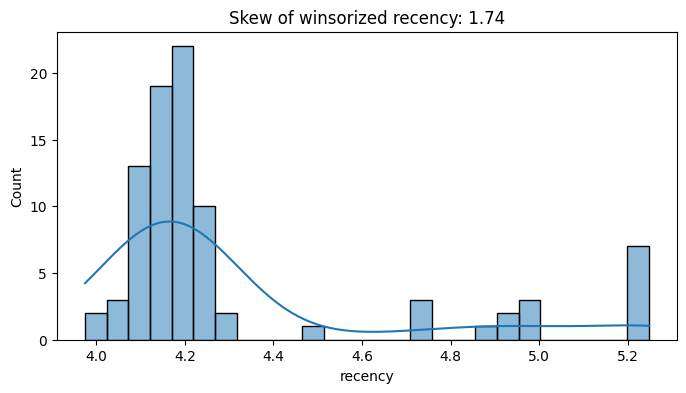

In [193]:
plt.figure(figsize=(8,4))

skew_log = stats.skew(df_wsr['recency'])
sns.histplot(df_wsr['recency'], kde=True)
plt.title('Skew of winsorized recency: %.2f' % (skew_log))

**Standard Scaler**

RFM values will be standardized to prepare for fitting to the K-Means Clustering Model.

In [194]:
scaler = StandardScaler()

rfm_table_scaled = scaler.fit_transform(df_wsr)
rfm_table_scaled = pd.DataFrame(rfm_table_scaled, columns=df_wsr.columns)
rfm_table_scaled.head()

,cust_id,recency,frequency,monetary
0,-1.671353,-0.643656,-0.552325,-0.516909
1,-1.633534,-0.441378,1.435378,0.980690
2,-1.595715,-0.349242,1.247070,1.015564
3,-1.557896,-0.351055,1.285927,1.355315
4,-1.520076,-0.606630,1.211201,1.211659


<Axes: xlabel='recency', ylabel='Count'>

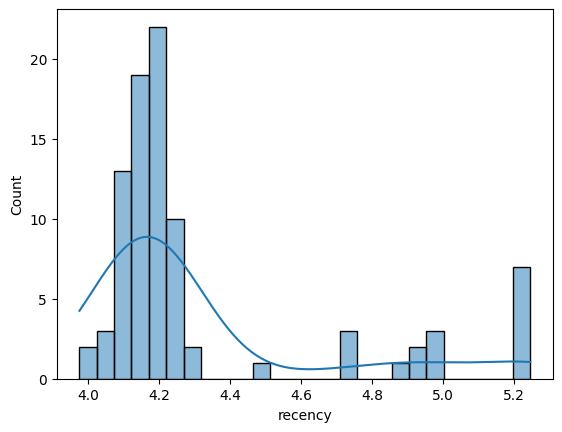

In [195]:
sns.histplot(df_wsr['recency'], kde=True)

In [196]:
rfm_table_scaled = rfm_table_scaled[['recency', 'frequency', 'monetary']]

### Compute RFM Score

In [197]:
rfm_table_scaled.head()

,recency,frequency,monetary
0,-0.643656,-0.552325,-0.516909
1,-0.441378,1.435378,0.980690
2,-0.349242,1.247070,1.015564
3,-0.351055,1.285927,1.355315
4,-0.606630,1.211201,1.211659


In [198]:
rfm_table_scaled.describe()

,recency,frequency,monetary
count,8.800000e+01,8.800000e+01,8.800000e+01
mean,-5.349256e-16,-9.335966e-17,3.027881e-17
std,1.005731e+00,1.005731e+00,1.005731e+00
min,-9.993322e-01,-1.458000e+00,-1.559715e+00
25%,-5.449814e-01,-5.814676e-01,-7.152634e-01
50%,-4.122872e-01,2.666687e-01,1.430045e-01
75%,-2.243740e-01,1.155904e+00,9.614247e-01
max,2.617222e+00,1.435378e+00,2.003493e+00


We will assign a score from 1 to 3 based on the tertile (divide the dataset into 3) assignment of each user's Recency, Frequency and Monetary values, with 1 being highest and 3 the lowest.

For Recency:
* Users with values close to 0 will receive a score of 1 since this means they recently made a purchase.
* Users with higher values (i.e. longer time since last purchase) will receive a score of 3.

For Frequency and Monetary:
* Users with the highest values will receive a score of 1 due to high transaction count and total amount spent.
* Conversely, users with lower values will receive a score of 3.

The final RFM score will be the total of the Recency, Frequency and Monetary scores.

In [199]:
# determine scores per tertile
r_scores = [1, 2, 3]
fm_scores = [3, 2, 1]

df_rfm['r_score'] = pd.qcut(df_rfm['recency'], q=3, labels=r_scores)
df_rfm['f_score'] =  pd.qcut(df_rfm['frequency'], q=3, labels=fm_scores)
df_rfm['m_score'] =  pd.qcut(df_rfm['monetary'], q=3, labels=fm_scores)
df_rfm['rfm_score'] = df_rfm[['r_score', 'f_score', 'm_score']].sum(axis=1)

In [200]:
df_rfm

,cust_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score
0,1,4.100097,307,23523.23,1,3,2,6
1,2,4.171243,972,56954.73,2,1,1,4
2,3,4.203649,909,57733.24,2,1,1,4
3,4,4.203011,922,65317.62,2,1,1,4
4,5,4.113120,897,62110.74,1,1,1,3
...,...,...,...,...,...,...,...,...
83,89,4.962845,9,2814.60,3,3,3,9
84,90,5.831882,10,6591.35,3,3,3,9
85,91,4.499810,4,244.26,3,3,3,9
86,92,4.997212,9,7317.52,3,3,3,9


In [201]:
rfm_scores = df_rfm.groupby('rfm_score').count()['cust_id'].reset_index()
rfm_scores

,rfm_score,cust_id
0,3,11
1,4,12
2,5,18
3,6,12
4,7,13
5,8,3
6,9,19


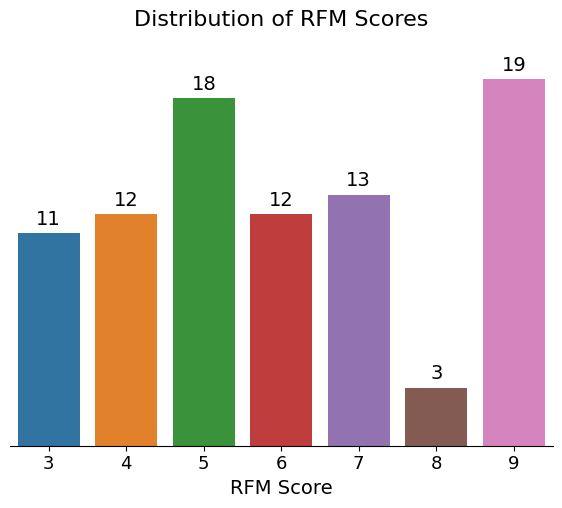

In [202]:
plt.figure(figsize=(7,5))

ax = sns.barplot(data=rfm_scores, x='rfm_score', y='cust_id')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=14, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.xlabel('RFM Score', fontsize=14)
plt.xticks(fontsize=13)
#plt.ylabel('Customer Count', fontsize=14)
plt.title('Distribution of RFM Scores', fontsize=16, pad=25)

sns.despine(left=True)
ax.get_yaxis().set_visible(False)

plt.show()

**Observation**

Based on RFM scores, customers with a score of 3-4 can be classified as the best customers who made recent purchases with the card, has a high transaction count and amount spent. Customers who scored 5 are customers with an averge transaction count and amount spend, meanwhile users with a score of 6 and 7 may be considered low spenders. Those with scores of 8-9 may be considered at-risk of churning due to low card usage and spending, and not having used the card for a long time.

## K Means

Here we will try to segment the users by feeding the raw RFM scores of the users into the K-means clustering model which is an unsupervised learning model and see if it will arrive at the same conclusions in the manual RFM score segmentation done above.

In [203]:
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
# distortions = []

wcss = {}
ssc = {}
K = range(2,10)

for k in K:
    #Building and fitting the model
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(rfm_table_scaled)
    kmeans_model.fit(rfm_table_scaled)

    # distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_,
    #                   'euclidean'),axis=1)) / RFM_Table_scaled.shape[0])
    # inertias.append(kmeanModel.inertia_)  ### sum of squared distances to closest cluster center
    wcss[k] = kmeans_model.inertia_ ### sum of squared distances to closest cluster center
    ssc[k] = silhouette_score(rfm_table_scaled, kmeans_model.labels_, metric='euclidean')

In [204]:
def find_elbow_point(wcss_values):
    deltas = [wcss_values[i] - wcss_values[i + 1] for i in range(len(wcss_values) - 1)]
    return deltas.index(max(deltas))

# Find the elbow point
elbow_point = find_elbow_point(list(wcss.values()))

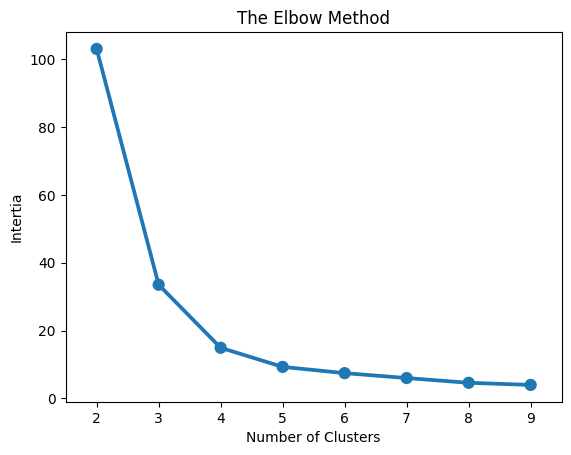

In [205]:
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Intertia')
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.show()

**Observation**

Using the Elbow Method of plotting the inertia of each cluster, we can see a significant decrease in inertia up to 4 clusters. Cluster 5 onwards do not return significant changes in the inertia value.

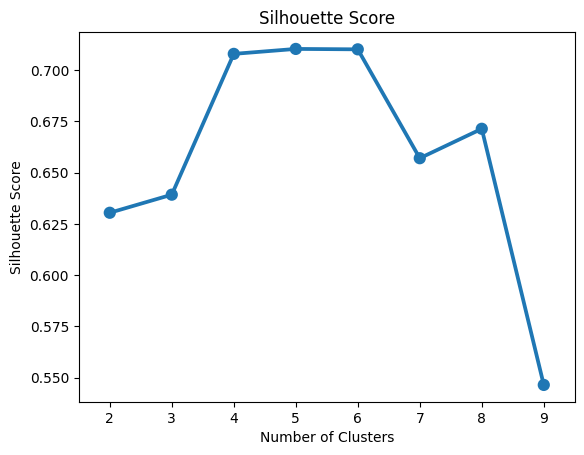

In [206]:
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
sns.pointplot(x=list(ssc.keys()), y=list(ssc.values()))
plt.show()

**Observation**

The silhoutte score reaches the peak at around 4-6 clusters. Using the result from the elbow method, 4 clusters may be the best way to segment the customer data.

In [207]:
def flattened_graph(normalised_df_rfm, clusters_number, original_df_rfm):

    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_

    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)

    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)

    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")

    return df_new

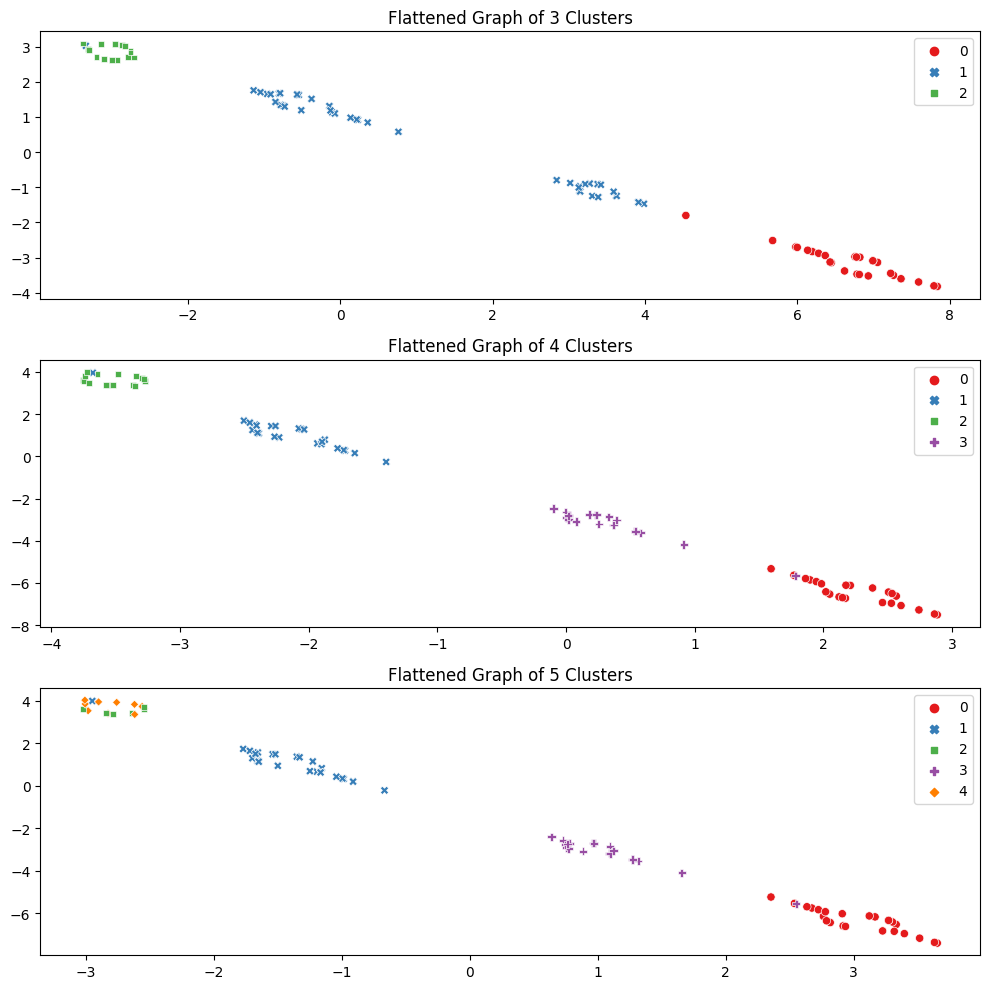

In [208]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = flattened_graph(rfm_table_scaled, 3, df_rfm[['recency','frequency','monetary']])

plt.subplot(3, 1, 2)
df_rfm_k4 = flattened_graph(rfm_table_scaled, 4,df_rfm[['recency','frequency','monetary']])

plt.subplot(3, 1, 3)
df_rfm_k5 = flattened_graph(rfm_table_scaled, 5, df_rfm[['recency','frequency','monetary']])

plt.tight_layout()

,recency,frequency,monetary,Cluster
0,4.100097,307,23523.23,1
1,4.171243,972,56954.73,0
2,4.203649,909,57733.24,0
3,4.203011,922,65317.62,0
4,4.113120,897,62110.74,0
...,...,...,...,...
83,4.962845,9,2814.60,2
84,5.831882,10,6591.35,2
85,4.499810,4,244.26,2
86,4.997212,9,7317.52,2


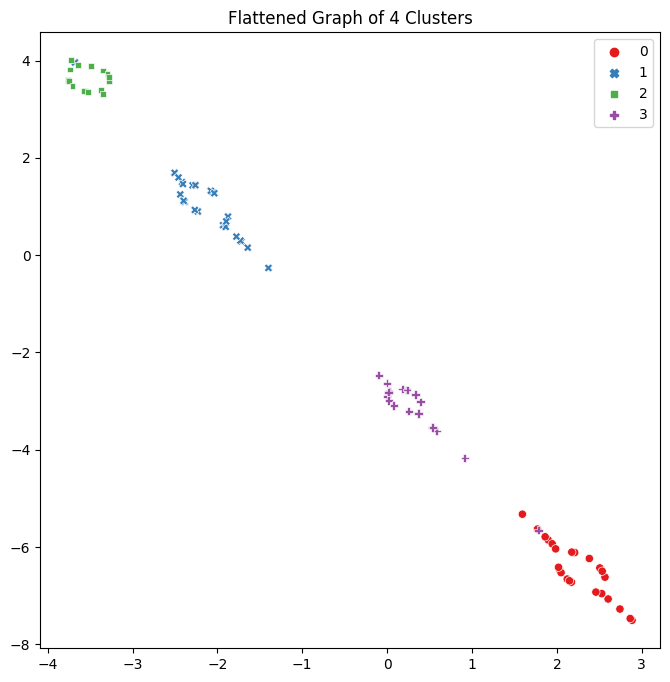

In [209]:
plt.figure(figsize=(8, 8))
flattened_graph(rfm_table_scaled, 4,df_rfm[['recency','frequency','monetary']])

**Aggregate the RFM values of the 4-cluster dataset for further analysis.**

In [210]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'recency': 'mean',
        'frequency': 'mean',
        'monetary': ['mean', 'count']
    }).round(0)

    return df_new

In [211]:
df_rfm_k4.head()

,recency,frequency,monetary,Cluster
0,4.100097,307,23523.23,1
1,4.171243,972,56954.73,0
2,4.203649,909,57733.24,0
3,4.203011,922,65317.62,0
4,4.113120,897,62110.74,0


In [212]:
df_rfm_k4_transformed = df_rfm_k4.copy()
df_rfm_k4_transformed['recency'] = np.expm1(df_rfm_k4_transformed['recency'])
df_rfm_k4_transformed.head()

,recency,frequency,monetary,Cluster
0,59.346154,307,23523.23,1
1,63.795918,972,56954.73,0
2,65.930131,909,57733.24,0
3,65.887446,922,65317.62,0
4,60.137168,897,62110.74,0


In [213]:
clustering = rfm_values(df_rfm_k4_transformed)
clustering

recency frequency monetary      
           mean      mean     mean count
Cluster                                 
0          64.0     917.0  63841.0    25
1          63.0     297.0  21375.0    25
2         193.0       8.0   4912.0    17
3          64.0     609.0  41568.0    21

## What does each cluster represent?
* **Cluster 0** is defined by the "Best Customers" segment which has recent purchases, are the most frequent buyers, and spent the most.
- The **Cluster 1** customers are the "Low Spenders" segment as they have several recent purchases for some time(R=3), but has less frequently frequent purchases and lower total amount spent.
- Customers in **Cluster 2** can be interpreted as customers at risk of churning as their last purchase is long ago (R=4),purchased very few (F=4) and spent little (M=4).Company has to come up with new strategies to make them permanent members.   
- **Cluster 3** customers are "Average Spenders" who made recent purchases and are in between the customers in Cluster 0 and 1 in terms of frequency of transactions and total amount spend.
- Notably, Clusters 0, 1 and 3 are mainly differentiated by the levels of frequency and total amount spent. These groups are mostly similar in terms of recency as they all have made recent purchases.

# Snake Plot

Using the snake plot will allow us to check how well defined the clusters are.

In [214]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm['CustomerID'] = df_rfm_original.index
    normalised_df_rfm['Cluster'] = list(df_rfm_kmeans['Cluster'])

    # # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm,
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['recency','frequency','monetary'],
                        var_name='Metric',
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')


    return

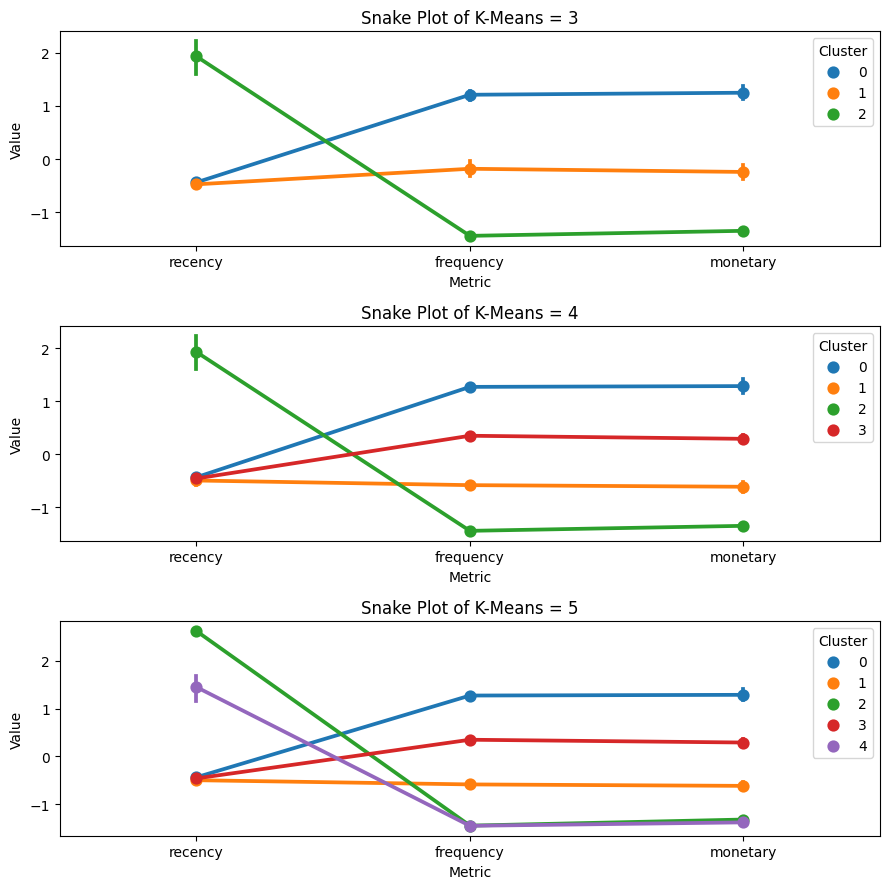

In [215]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(rfm_table_scaled, df_rfm_k3, df_rfm[['recency','frequency','monetary']])

plt.subplot(3, 1, 2)

plt.title('Snake Plot of K-Means = 4')
snake_plot(rfm_table_scaled, df_rfm_k4, df_rfm[['recency','frequency','monetary']])

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(rfm_table_scaled, df_rfm_k5, df_rfm[['recency','frequency','monetary']])

plt.tight_layout()

**Observation**

At 4 clusters, the segments are well defined except for the recency metric. As mentioned above, Clusters 0, 1, and 3 are similar in terms of recency.

## Count Plot

This is to check if the customers are well distributed among the clusters.

In [216]:
def countplot(cluster, cluster_number):
  original_scale = df_rfm[['recency','frequency','monetary']]
  original_scale['Cluster'] = list(cluster['Cluster'])

  sns.catplot(
    data=original_scale,
    x="Cluster",
    kind="count"
  )
  plt.show()

  return

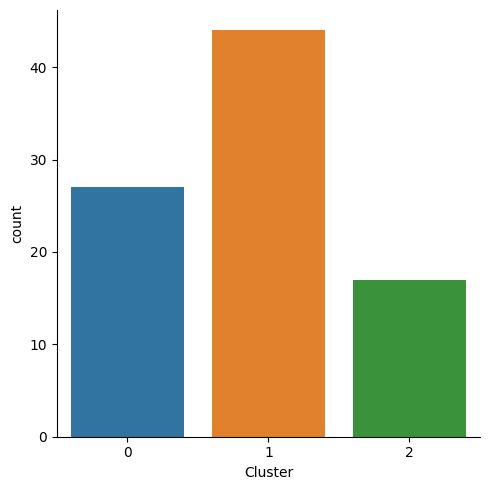

In [217]:
countplot(df_rfm_k3, 3)

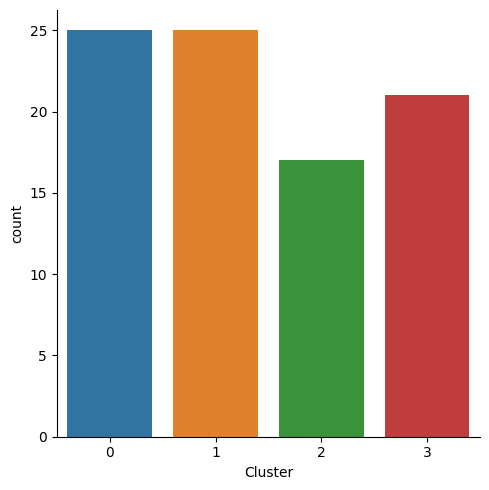

In [218]:
countplot(df_rfm_k4, 4)

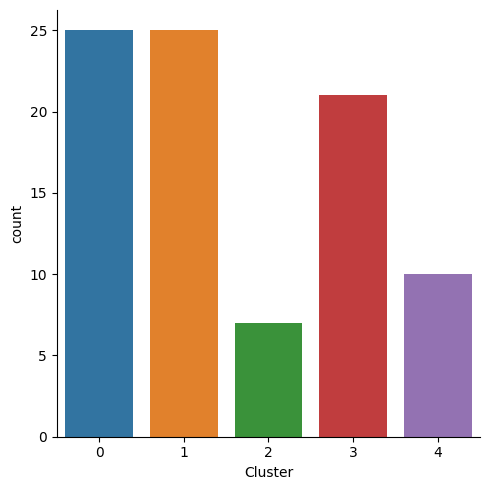

In [219]:
countplot(df_rfm_k5, 5)

**Observation**

Customer distribution is most even when using 4 clusters.

### Map back clusters to the 2021 dataset

In [220]:
cust_clusters = df_rfm.join(df_rfm_k4['Cluster'])
cust_clusters.head()

,cust_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,Cluster
0,1,4.100097,307,23523.23,1,3,2,6,1
1,2,4.171243,972,56954.73,2,1,1,4,0
2,3,4.203649,909,57733.24,2,1,1,4,0
3,4,4.203011,922,65317.62,2,1,1,4,0
4,5,4.113120,897,62110.74,1,1,1,3,0


In [221]:
cluster_mapping = dict(zip(cust_clusters['cust_id'], cust_clusters['Cluster']))

In [222]:
df_2021_clustered = df_2021.copy()
df_2021_clustered['cluster'] = df_2021_clustered['cust_id']
df_2021_clustered['cluster'] = df_2021_clustered['cluster'].map(cluster_mapping)

In [223]:
df_2021_clustered.head()

,cust_id,cc_num,gender,city,city_pop,job,dob,age,acct_num,acct_num2,trans_num,unix_time,trans_year,trans_month,trans_year_month,category,amt,date,cluster
3,4,4.870000e+15,M,San Fernando,121812,unspecified,1964-07-18,59,8.630000e+11,8.630000e+11,45bbe714e51ab8a375454d39a190b0cb,2021-02-11 17:15:04,2021,02,2021-02,food_dining,38.61,2021-02-11,0
7,7,1.800000e+14,M,Balanga,96061,manufacturing systems engineer,1950-05-14,73,2.330000e+11,2.330000e+11,c371800cdd75b7373b0a883e9ea38450,2021-09-30 16:15:57,2021,09,2021-09,kids_pets,47.87,2021-09-30,3
10,8,3.470000e+14,M,Antipolo,776386,seismic interpreter,1959-05-19,64,5.640000e+11,5.640000e+11,44fec72badccf385eec1f6bf27ccdf65,2021-02-10 18:13:45,2021,02,2021-02,personal_care,58.04,2021-02-10,1
14,12,1.800000e+14,M,Marikina,450741,unspecified,1955-08-12,68,3.461474e+10,3.461474e+10,3a86393194aa83069765af258572b4cb,2021-03-08 03:29:16,2021,03,2021-03,shopping_pos,127.83,2021-03-08,1
15,13,3.520000e+15,M,Malabon,365525,broadcast journalist,1957-04-05,66,5.870000e+11,5.870000e+11,c6fd5f74c9529755d5c190c1cf2b2610,2021-10-27 01:54:23,2021,10,2021-10,grocery_pos,89.45,2021-10-27,0


In [224]:
cluster_by_category = df_2021_clustered.groupby(['cluster', 'category']).agg({'trans_num': 'count', 'amt':'sum'})

In [225]:
cluster_by_category = cluster_by_category.reset_index()

**Total Transactions per Category per Cluster**

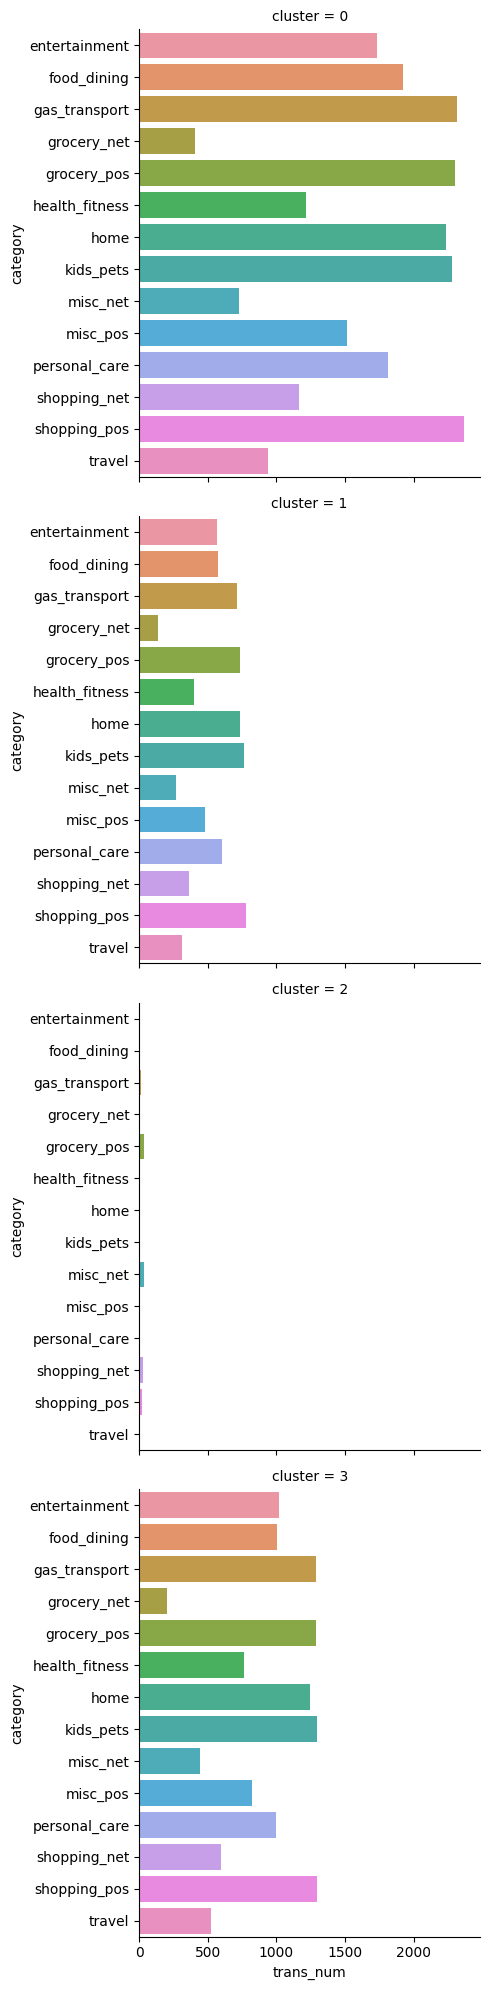

In [226]:
sns.catplot(data=cluster_by_category, y='category', x ='trans_num', kind='bar',row='cluster')

**Total Amoount Spent per Category per Cluster**

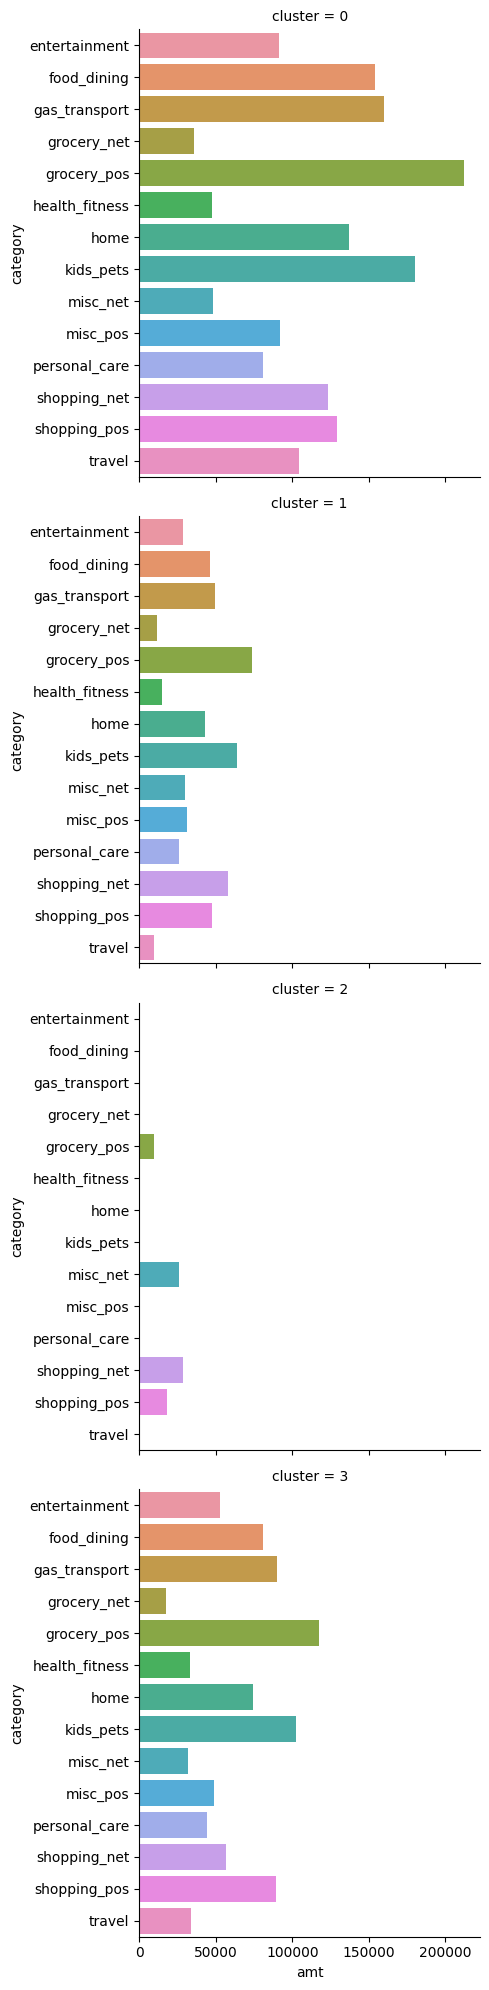

In [227]:
sns.catplot(data=cluster_by_category, y='category', x ='amt', kind='bar',row='cluster')

**Observation**

The distribution of total transactions and amount spent per category largely follows the overall category distribution conducted in the EDA. Notably, the at-risk of churning cluster (Cluster 2) mainly spends on groceries, shopping and miscellaneous items.